# Features x & y : Laurent

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DATA_FOLDER = "./data/"
PATHS_AND_GRAPH = DATA_FOLDER + "wikispeedia_paths-and-graph/"
PATHS_FINISHED = PATHS_AND_GRAPH + "paths_finished.tsv"
PATHS_UNFINISHED = PATHS_AND_GRAPH + "paths_unfinished.tsv"

# data exploration
paths_finished = pd.read_csv(
    PATHS_FINISHED,
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    encoding="utf-8",
    skiprows=16,
).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit="s")

paths_unfinished = pd.read_csv(
    PATHS_UNFINISHED,
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    encoding="utf-8",
    skiprows=17,
).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit="s")

# Remove annoying future warnings in pandas and seaborn with new python versions
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## Do longer paths lead to the player giving up?

Can we make some sort of extrapolation from this data?

54 paths given up on in common with finished


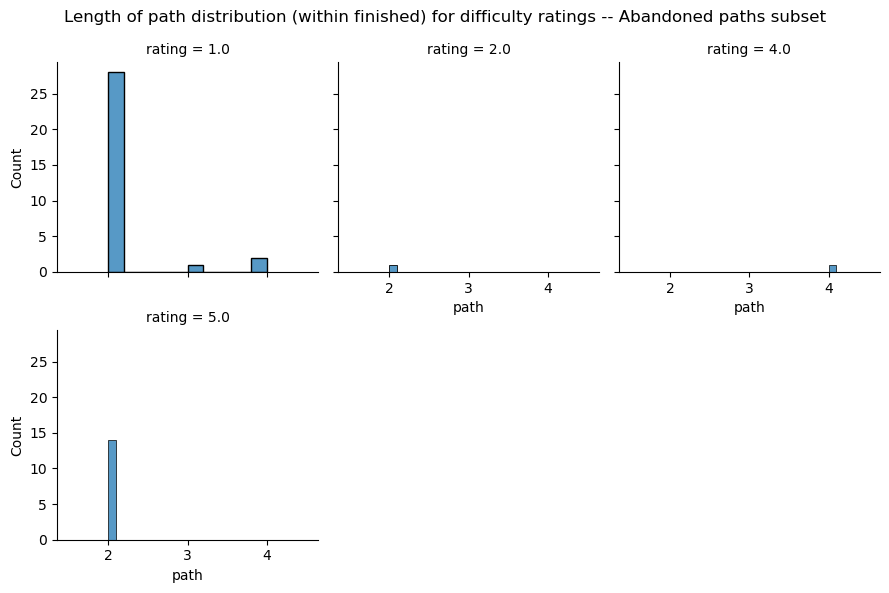

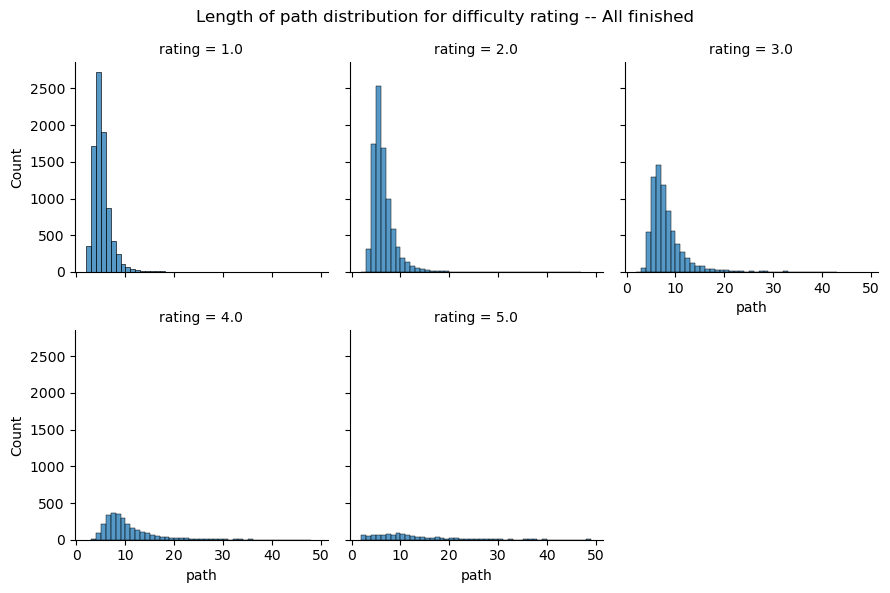

In [2]:
paths_finished_set = set(paths_finished["path"])  # Get finished paths
given_up_paths = set(paths_unfinished["path"])  # Get unfinished paths

# These are both sets of strings

common_paths = paths_finished_set.intersection(given_up_paths)
print(len(common_paths), "paths given up on in common with finished")

common_path_idx = np.concatenate(
    [np.where(paths_finished["path"] == x)[0] for x in common_paths]
)


paths_and_len_common = paths_finished.iloc[common_path_idx][["path", "rating"]].copy()
paths_and_len_common["path"] = paths_and_len_common["path"].apply(
    lambda x: len(x.split(";"))
)


p1 = sns.FacetGrid(paths_and_len_common, col="rating", col_wrap=3)
p1.map_dataframe(sns.histplot, data=paths_and_len_common, x="path", bins=10)
p1.figure.suptitle(
    "Length of path distribution (within finished) for difficulty ratings -- Abandoned paths subset"
)
p1.figure.tight_layout()
plt.show()

paths_and_len_all = paths_finished[["path", "rating"]].copy()
paths_and_len_all["path"] = paths_and_len_all["path"].apply(lambda x: len(x.split(";")))

paths_and_len_all = paths_and_len_all.sort_values(by="path")
paths_and_len_all = paths_and_len_all[:-50]

p2 = sns.FacetGrid(paths_and_len_all, col="rating", col_wrap=3)
p2.map_dataframe(sns.histplot, data=paths_and_len_all, x="path", binwidth=1)
p2.figure.suptitle("Length of path distribution for difficulty rating -- All finished")
p2.figure.tight_layout()
plt.show()

It seems that length of path does give some information about the rating that the path will recieve, somewhat. It could be used as a predictor in a linear model, for example. However, it does not seem like we can make any inference about giving up, as the data is clearly insufficient.

## What does the average time taken per edge look like?

Is it a nice distribution?

,durationInSec,path,path_length,coarse_mean_time
0,166,14th_century;15th_century;16th_century;Pacific...,9,18.444444
1,88,14th_century;Europe;Africa;Atlantic_slave_trad...,5,17.600000
2,138,14th_century;Niger;Nigeria;British_Empire;Slav...,8,17.250000
3,37,14th_century;Renaissance;Ancient_Greece;Greece,4,9.250000
4,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,7,25.000000
...,...,...,...,...
51313,66,Yagan;Ancient_Egypt;Civilization,3,22.000000
51314,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,9,18.333333
51315,228,Yagan;Australia;England;France;United_States;T...,7,32.571429
51316,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,4,14.000000


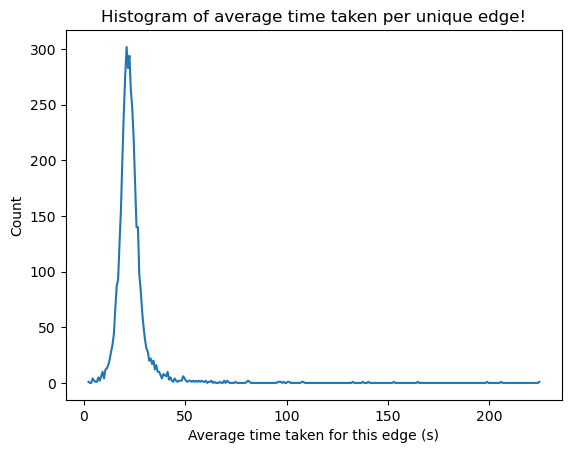

'Gaussianity' shaprio test p-value: 4.676840558622769e-33


In [3]:
from collections import defaultdict
import scipy

paths_and_time_fin = paths_finished[["durationInSec", "path"]].copy()
paths_and_time_fin["path_length"] = paths_and_time_fin["path"].apply(
    lambda x: len(x.split(";"))
)
paths_and_time_fin["coarse_mean_time"] = (
    paths_and_time_fin["durationInSec"] / paths_and_time_fin["path_length"]
)

display(paths_and_time_fin)

times_per_edge = defaultdict(list)

for idx, row in paths_and_time_fin.iterrows():
    elems_path = row["path"].split(";")
    for elem in elems_path:
        times_per_edge[elem].append(row["durationInSec"] / row["path_length"])

times_per_edge_micro = {key: np.mean(value) for key, value in times_per_edge.items()}

# p3 = sns.histplot(x = list(times_per_edge_micro.values()), bins=320)
np_hist = np.histogram(list(times_per_edge_micro.values()), bins=320)
p3 = sns.lineplot(x=np_hist[1][:-1], y=np_hist[0])
plt.xlabel("Average time taken for this edge (s)")
plt.ylabel("Count")
plt.title("Histogram of average time taken per unique edge!")
plt.show()

print("'Gaussianity' shaprio test p-value:", scipy.stats.shapiro(np_hist[0]).pvalue)

We can clearly see a Gaussian distribution of this data, which makes it particularly appealing.
We also already have a dataframe (see just above) which contains the metrics for each path, which also makes it easier for use later on!

## Applying the BERTscore semantic similarity metric

100%|██████████| 51318/51318 [02:13<00:00, 385.07it/s]
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/laurent/micromamba/envs/ada/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_36310/311717746.py:39: RuntimeWarning: Mean of empty slice
  'mean_rating':[np.nanmean(a[:, 0]) for a in global_dict.values()]


,edge,mean_bert_score,mean_rating
0,"(14th_century, 15th_century)",0.999987,2.600000
1,"(15th_century, 16th_century)",0.999637,2.428571
2,"(16th_century, Pacific_Ocean)",0.700767,NaN
3,"(Pacific_Ocean, Atlantic_Ocean)",0.990600,2.521739
4,"(Atlantic_Ocean, Accra)",0.098035,NaN
...,...,...,...
55142,"(Yagan, Folklore)",0.706183,3.000000
55143,"(A_Christmas_Carol, Novel)",0.582377,3.000000
55144,"(Yagan, Australia)",0.979503,NaN
55145,"(Yarralumla%2C_Australian_Capital_Territory, A...",0.842705,1.000000


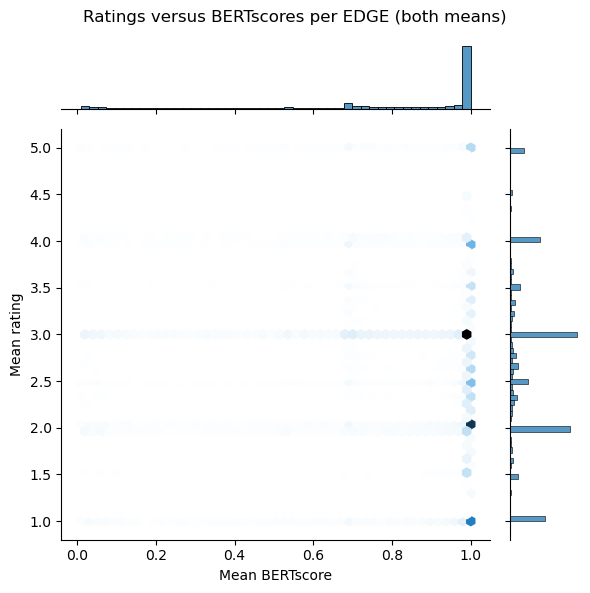

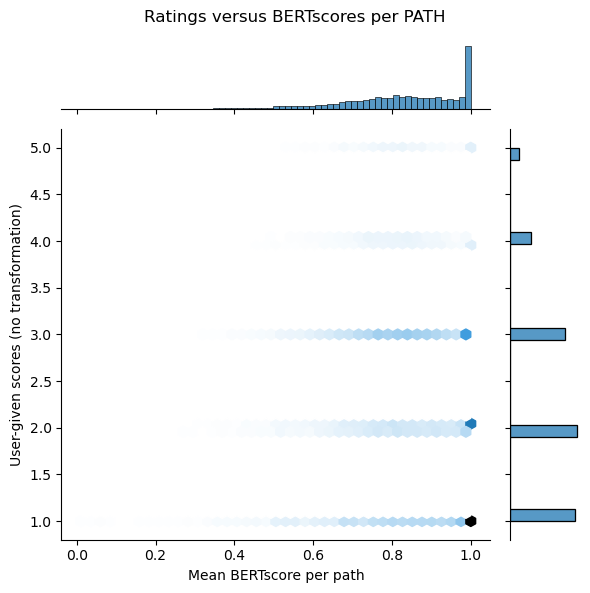

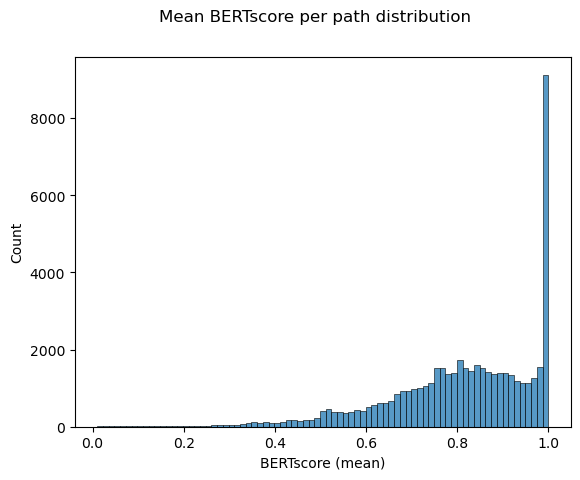

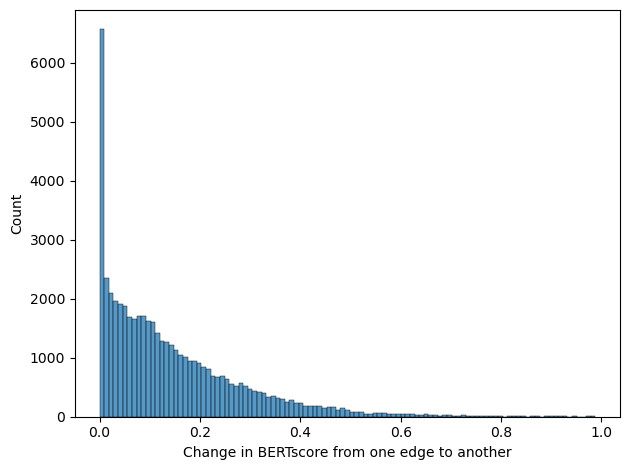

'Gaussianity' shaprio test p-value for mean BERTscore per EDGE's histogram: 1.9635877044604022e-19


In [5]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from tqdm import tqdm


tokenizer = AutoTokenizer.from_pretrained(
    "dslim/bert-base-NER"
)  # Named entity recognition-specific model!


def compute_sim(s1, s2):
    enc1 = tokenizer.encode(s1, return_tensors="pt").reshape(1, -1)
    enc2 = tokenizer.encode(s2, return_tensors="pt").reshape(1, -1)

    trunc = min(enc1.size(dim=1), enc2.size(dim=1))

    enc1 = enc1[:, :trunc]
    enc2 = enc2[:, :trunc]

    return cosine_similarity(enc1, enc2).squeeze().item()


sucessive_pairs = [
    [(x.split(";")[i], x.split(";")[i + 1]) for i in range(len(x.split(";")) - 1)]
    for x in paths_finished["path"].to_list()
]
sucessive_pairs_encoded = [[compute_sim(*a) for a in x] for x in tqdm(sucessive_pairs)]

sucessive_pairs_encoded_mean = np.array(
    [np.mean(x) for x in sucessive_pairs_encoded]
)  # Mean BERTscore per path
aligned_finished_scores = paths_finished["rating"].to_numpy()[
    ~np.isnan(sucessive_pairs_encoded_mean)
]  # This is for later
sucessive_pairs_encoded_mean = sucessive_pairs_encoded_mean[
    ~np.isnan(sucessive_pairs_encoded_mean)
]  # Remove NaNs

from collections import defaultdict

global_dict = defaultdict(list)

for i in range(len(sucessive_pairs)):
    local_rating = paths_finished["rating"][i]
    for key, value in zip(sucessive_pairs[i], sucessive_pairs_encoded[i]):
        global_dict[key].append((local_rating, value))

global_dict = {key: np.array(value) for key, value in global_dict.items()}
edge_score_df = pd.DataFrame(
    {
        "edge": global_dict.keys(),
        "mean_bert_score": [np.nanmean(a[:, 1]) for a in global_dict.values()],
        "mean_rating": [np.nanmean(a[:, 0]) for a in global_dict.values()],
    }
)


display(edge_score_df)

p4 = sns.jointplot(
    data=edge_score_df,
    x="mean_bert_score",
    y="mean_rating",
    kind="hex",
)
p4.figure.suptitle("Ratings versus BERTscores per EDGE (both means)")
plt.xlabel("Mean BERTscore")
plt.ylabel("Mean rating")
p4.figure.tight_layout()
plt.show()

mean_BERT_and_score = pd.DataFrame(
    {
        "successive_pairs_mean": sucessive_pairs_encoded_mean,
        "finished_scores": aligned_finished_scores,
    }
)

p6 = sns.jointplot(
    data=mean_BERT_and_score, x="successive_pairs_mean", y="finished_scores", kind="hex"
)
p6.figure.suptitle("Ratings versus BERTscores per PATH")
plt.ylabel("User-given scores (no transformation)")
plt.xlabel("Mean BERTscore per path")
p6.figure.tight_layout()
plt.show()

# ------------------------------

p5 = sns.histplot(x=sucessive_pairs_encoded_mean)
p5.figure.suptitle("Mean BERTscore per path distribution")
plt.ylabel("Count")
plt.xlabel("BERTscore (mean)")
plt.show()

p7 = sns.histplot(x=np.abs(np.diff(sucessive_pairs_encoded_mean)))
p5.figure.suptitle("Incremental changes in pair semantic similarity")
plt.xlabel("Change in BERTscore from one edge to another")
plt.ylabel("Count")
p7.figure.tight_layout()
plt.show()

print(
    "'Gaussianity' shaprio test p-value for mean BERTscore per EDGE's histogram:",
    scipy.stats.shapiro(
        np.histogram(edge_score_df["mean_bert_score"].to_numpy(), bins=80)[0]
    ).pvalue,
)

This data seems relatively gaussian per path, and both the edge and path metrics have interesting distributions both on their own and when cross-compared. Our subsequent analysis should be interesting!